In [16]:
#!/usr/bin/env python3
from traitlets.config.manager import BaseJSONConfigManager
from pathlib import Path

path = Path.home() / ".jupyter" / "nbconfig"
cm = BaseJSONConfigManager(config_dir=str(path))
cm.update("rise", {"scroll": True})

{'scroll': True}

# 個人的に面白いと思ったアルゴリズムの話（画像処理編）

Studdi@2020-10-20 Masahiro Wada

## はじめに

これまでの経験の中で，

* あまり画像処理の知識を必要としない
* 実装・理論の観点「あー」っと感じた

そんなアルゴリズムを幾つか紹介します.

なので，実用性はあまり高くはありません．

## 輝度信号をG信号で代用する

輝度信号はRGB信号から以下の様に計算できます．

$$
\begin{aligned}
Y &= 0.299 * R + 0.587 * G + 0.114 * B
\end{aligned}
$$

実行環境が非常に非力な場合，以下の近似でもそれなりの結果を得ることができます．

$$
\begin{aligned}
Y &= G
\end{aligned}
$$

### 結果を確認してみよう

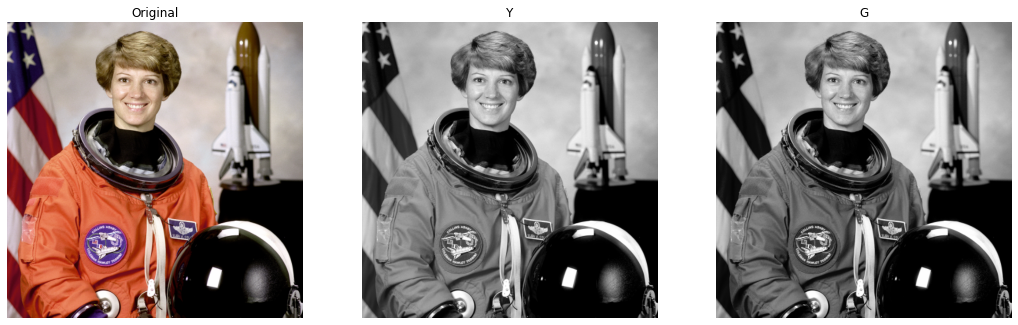

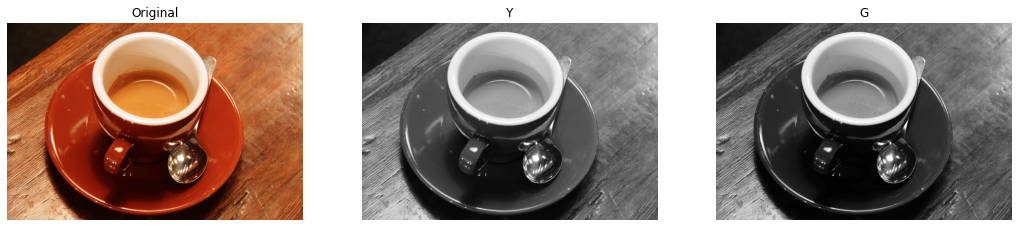

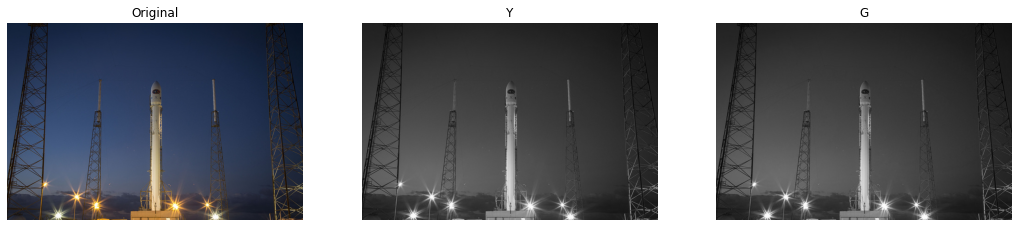

In [17]:
import matplotlib.pyplot as plt

from skimage import data, color, transform
import numpy as np

images = ("astronaut", "coffee", "rocket")

def _to_y(img):
    # RGB -> 輝度変換
    return np.repeat(color.rgb2yuv(img)[:, :, 0:1], 3, axis=2)

def _to_g(img):
    # RGB -> G変換
    return np.repeat(img[:, :, 1:2], 3, axis=2)

def _imshow(img, n, title):
    # 画像を表示
    plt.subplot(1, 3, n)
    plt.axis("off")
    plt.title(title)
    plt.imshow(img)

for name in images:
    img = getattr(data, name)()
    plt.figure(figsize=(18,6))
    # オリジナル画像を表示
    _imshow(img, 1, "Original")
    # 輝度信号画像を表示
    _imshow(_to_y(img), 2, "Y")
    # G信号画像を表示
    _imshow(_to_g(img), 3, "G")
plt.show()

### なにがうれしいの？

積和計算を行う必要がなくなる．

### なぜだろう

以下の様に，輝度信号$Y$の$58.7\%$がG信号であるため，G信号のみでも結構いける．

$$
\begin{aligned}
Y &= 0.299 * R + 0.587 * G + 0.114 * B
\end{aligned}
$$

## Gaussian BlurをBox Blurで代用する

細かいパラメータとかに拘りはないんで，ざっくりといい感じにボカしたい！でも負荷は軽く！！というユースケースは結構あると思います．

そんな時は，以下に示すBox Blurを3回適用してみると良いです．

ここで，$I_{x,y}$は元画像における座標$(x, y)$の画素値，$I'_{x,y}$はブラー画像における座標$(x,y)$の画素値を表します．

$$
\begin{aligned}
I'_{x,y} &= \frac{1}{9} \sum_{i=-1}^{1}\sum_{j=-1}^{1}I_{x+i, y+j}
\end{aligned}
$$

### 結果を確認してみよう

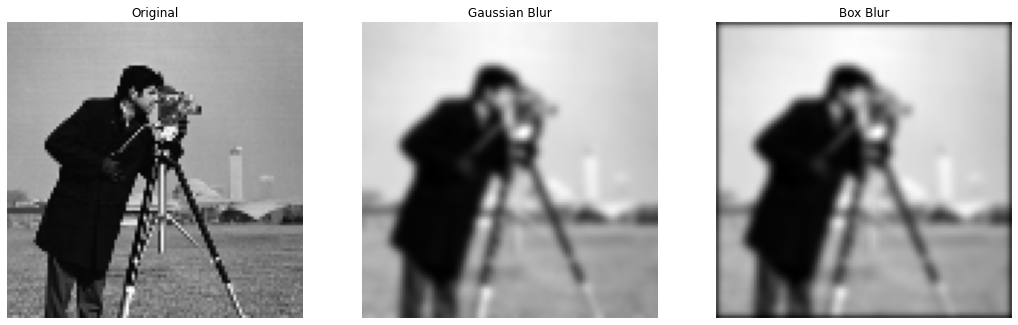

In [18]:
import matplotlib.pyplot as plt
import math

from skimage import data, filters, transform
from scipy.ndimage import shift
import numpy as np

def _boxblur(img):
    # 3x3 の　Box Blurを適用
    img = img + shift(img, (1,0)) + shift(img, (-1, 0))
    img = img + shift(img, (0, 1)) + shift(img, (0, -1))
    return img / 9

def _imshow(img, n, title):
    plt.subplot(1, 3, n)
    plt.axis("off")
    plt.title(title)
    plt.imshow(img, cmap="gray")

img = transform.rescale(data.camera(), 0.2, anti_aliasing=False)
plt.figure(figsize=(18,6))
# オリジナル画像を表示
_imshow(img, 1, "Original")
# Gaussian Blur
_imshow(filters.gaussian(img, math.sqrt(2)), 2, "Gaussian Blur")
_imshow(_boxblur(_boxblur(_boxblur(img))), 3, "Box Blur")
plt.show()

### なぜだろう？

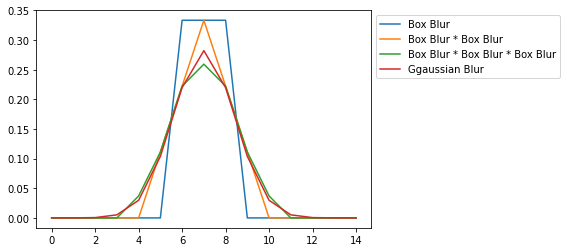

In [19]:
import math
import numpy as np
from scipy.signal import convolve, gaussian

def _pad_zeros(array, n):
    # プロットするため余白をセット
    return np.pad(array, (n - len(array)) // 2)

# 1回Box Blurを適用した時のカーネル
kernel_0 = np.ones(3)  / 3
# 2回Box Blurを適用した時のカーネル
kernel_1 = convolve(kernel_0, kernel_0)
# 3回Box Blurを適用した時のカーネル
kernel_2 = convolve(kernel_0, kernel_1)

# Gaussian Blurを適用した時のカーネル
std = math.sqrt(2)
gauss_kernel = gaussian(2 * len(kernel_2) + 1, std) / (math.sqrt(2 * math.pi) * std)

N = len(gauss_kernel)
# 各カーネルをプロット
plt.plot(_pad_zeros(kernel_0,  N), label="Box Blur")
plt.plot(_pad_zeros(kernel_1,  N),  label="Box Blur * Box Blur")
plt.plot(_pad_zeros(kernel_2,  N),  label="Box Blur * Box Blur * Box Blur")
plt.plot(gauss_kernel, label="Ggaussian Blur" )
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

3回Box blurを適用した時のカーネルがGaussian blurのカーネルの良い近似となっている

### 何がうれしいの？

Box blurは計算を工夫することで，$O(1)$で計算できる．

## 3x3 Median filterの簡略化

Meidan filterとは注目画素とその近傍画素の中央値を出力値とするフィルタです．3x3のMedian filterを単純に実装すると，

1. 入力９画素をソート
1. 5番目の値を出力

というステップになります．

しかしながら，この処理には駄が存在します.それは，中央値を求める際，データ全体をソートする必要はないからです．

そこで，

1. 入力9画素中，中央値ではない２画素を取り除く
1. 残りの7画素中，中央値ではない２画素を取り除く
1. 残りの5画素中，中央値ではない２画素を取り除く
1. 残りの3画素中，中央値ではない２画素を取り除く
1. 残った1画素を出力

というステップで中央値を実現します．

### 結果を確認してみよう

In [20]:
import numpy as np


def _sort2(a, b):
    # a, bを昇順に並び替える
    return (b, a) if b < a else (a, b)


def _min3(a, b, c):
    a, b = _sort2(a, b)
    a, c = _sort2(a, c)
    return a, b, c # a < b, a < c　　


def _max3(a, b, c):
    a, b = _sort2(a, b)
    b, c = _sort2(b, c)
    return a, b, c # a < c, b < c


def _drop_min_max3(a, b, c):
    # a, b, cから最大値と最小値を取り除く
    a, b, c = _max3(a, b, c)
    a, b = _sort2(a, b)
    return b


def _drop_min_max4(a, b, c, d):
    # a, b, c, dから最大値と最小値を取り除く
    a, b = _sort2(a, b)
    c, d = _sort2(c, d)
    a, c = _sort2(a, c)
    b, d = _sort2(b, d)
    return c, b


def _drop_min_max5(a, b, c, d, e):
    # a, b, c, d, eから最大値と最小値を取り除く
    a, b = _sort2(a, b)
    c, d = _sort2(c, d)
    a, c, e = _min3(a, c, e)
    b, d, e = _max3(b, d, e)
    return c, b, d


def _drop_min_max6(a, b, c, d, e, f):
    # a, b, c, d, e, f から最大値と最小値を取り除く
    a, b = _sort2(a, b)
    c, d = _sort2(c, d)
    e, f = _sort2(e, f)
    a, c, e = _min3(a, c, e)
    b, d, f = _max3(b, d, f)
    return c, e, b, d


def _median(v0, v1, v2, v3, v4, v5, v6, v7, v8):
    # 9要素中の中央値ではない2要素を取り除く
    v1, v2, v3, v4 = _drop_min_max6(v0, v1, v2, v3, v4, v5)
    # 7要素中の中央値ではない2要素を取り除く
    v2, v3, v4 = _drop_min_max5(v1, v2, v3, v4, v6)
    # 5要素中の中央値ではない2要素を取り除く
    v3, v4 = _drop_min_max4(v2, v3, v4, v7)
    # 3要素中の中央値ではない2要素を取り除く
    return _drop_min_max3(v3, v4, v8)

# ランダムな値を９個用意する
a = np.random.randint(0, 255, 9)
assert int(_median(*a)) == int(np.median(a))
a, int(_median(*a)), int(np.median(a))

(array([165,  63,   0,  43, 250,  64, 225,  36,  92]), 64, 64)

## なぜだろう？

* 9要素から任意の6要素を選んだ時，その最大値と最小値は中央値にはならない

![](./median.png)

* 7要素から任意の5要素を選んだ時，その最大値と最小値は中央値にはならない
* 5要素から任意の4要素を選んだ時，その最大値と最小値は中央値にはならない

## なにがうれしいの？

* 比較回数が単純にソートする場合よりも少ない
* 各２要素及び３要素の比較処理が並列に動作可能
* Median filterが高速に実装できるかも？

## 積分画像の省メモリ化

積分画像とは画像処理で多様される画像の中間表現の一種です．以下のように定義されます．

$$
\begin{aligned}
S(u, v) &= \sum_{x=0}^{x \leq u}\sum_{y=0}^{y \leq v} I(x, y)
\end{aligned}
$$

積分画像の各要素は，自身の左上にある全画素値の総和となっています．一般的には累積和などとも呼ばれています．

画像処理において，積分画像は一定領域の画素値の総和を高速に計算するために用いられます．

領域総和$\Sigma$は積分画像の４点より以下の様に計算できます．

![](./ii.jpg)

$$
\begin{aligned}
\Sigma &= \Sigma_{A} - \Sigma_{B} - \Sigma_{C} + \Sigma_{D}
\end{aligned}
$$


積分画像における各要素のデータ型はどの様に決定するのが適切でしょうか？

領域の画素値の総和を計算するという点に特化すると，以下の値$\Sigma_{H*W}$を適切に表現できるデータ型となります．

ここで，$W$は領域幅を，$H$は領域高さを，$I_{max}$は画素値の最大値を表します．

$$
\begin{aligned}
\Sigma_{H*W} &= H * W * I_{max}
\end{aligned}
$$

### 結果を確認してみよう

<ipython-input-22-c59364e95e99>:17: RuntimeWarning: overflow encountered in ushort_scalars
  return img[bottom, right] - img[bottom, left] - img[top, right] + img[top, left]


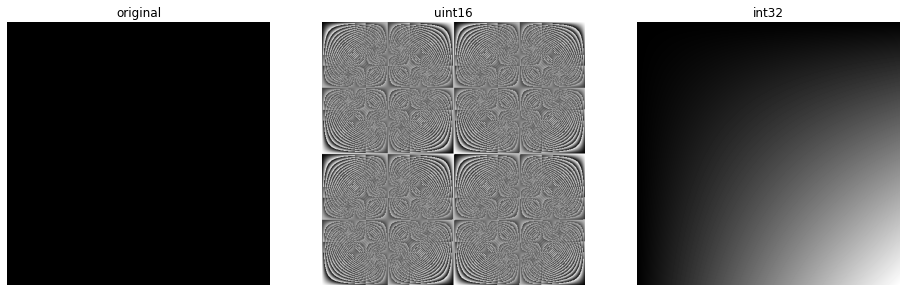

In [22]:
import numpy as np
import random


def _integrate16(img):
    # uint16で積分画像を作成
    return img.cumsum(axis=0, dtype=np.uint16).cumsum(axis=1, dtype=np.uint16)


def _integrate32(img):
    # int32で積分画像を作成
    return img.cumsum(axis=0, dtype=np.int32).cumsum(axis=1, dtype=np.int32)


def _sum(img, left, top, right, bottom):
    # 積分画像から(left, top) - (right, bottom)で指定される領域の総和を計算
    return img[bottom, right] - img[bottom, left] - img[top, right] + img[top, left]

# 入力画像サイズ
img_width = 512
img_height = 512

# 全画素を255で初期化
img_255 = 255 * np.ones((img_height, img_width), dtype=np.uint8)
#img_255 = np.random.randint(255, size=(img_height, img_width), dtype=np.uint8)

# 積分画像を作成
integrate_255_16 = _integrate16(img_255)
integrate_255_32 = _integrate32(img_255)

# オリジナル画像，積分画像（uint16), 積分画像(int32)の表示
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.axis("off")
plt.title("original")
plt.imshow(img_255, cmap="gray")
plt.subplot(1, 3, 2)
plt.axis("off")
plt.title("uint16")
plt.imshow(integrate_255_16, cmap="gray")
plt.subplot(1, 3, 3)
plt.axis("off")
plt.title("int32")
plt.imshow(integrate_255_32, cmap="gray")

max_area = 65535 // 255
for i in range(4096):
    # 総和を計算する矩形サイズ
    w = random.randint(1, math.floor(math.sqrt(max_area)))
    h = math.floor(max_area / w)
    
    # 総和を計算する矩形の座標
    left = random.randint(0, integrate_255_16.shape[1] - w - 1)
    top = random.randint(0, integrate_255_16.shape[0] - h - 1)
    right = left + w
    bottom = top + h
    
    # 総和の比較
    assert _sum(integrate_255_16, left, top, right, bottom) == _sum(
        integrate_255_32, left, top, right, bottom
    )

## なぜだろう？

剰余は以下の関係が成り立ちます

$$
\begin{aligned}
\left(a + b\right) \ \mathrm{mod}\ N &= \left(a \ \mathrm{mod}\ N\right) + \left(b \ \mathrm{mod}\ N\right) \ \mathrm{mod}\ N
\end{aligned}
$$

従って，$(l, t, r, b)$で表現される矩形領域のuint16による総和計算は

$$
\begin{aligned}
\Sigma &= 
\left(S(r,b) \ \mathrm{mod}\ 65536\right) \\
&- \left(S(r,t) \ \mathrm{mod}\ 65536\right) \\
&- \left(S(l,b) \ \mathrm{mod}\ 65536\right) \\
&+ \left(S(l,t) \ \mathrm{mod}\ 65536\right) \\
&= \left(S(r,b) - S(r,t) - S(l,b) + S(l,t) \right) \ \mathrm{mod}\ 65536 \\
総和領域の制約より\\
&= S(r,b) - S(r,t) - S(l,b)+ S(l,t)
\end{aligned}
$$

### なにがうれしいの？

* メモリ使用量が減る
* SIMDなど特殊な命令が使える様になる場合があるかも？

## ポアソン方程式による画像合成

ソース画像の一部（マスク領域）をターゲット画像に合成することを考えます．単純に合成すると以下のようになります．各画像は左から，ソース画像，マスク画像，ターゲット画像，合成画像となります．

![](./simple_blend.png)

この結果を改善するため，Poisson Image Editingと呼ばれるのモデルを考えます．

ここで，$f$は合成画像を，$f*$はターゲット画像を，$g$はソース画像を，$\Omega$はマスク領域を，$\partial \Omega$はマスク領域の境界をそれぞれ表します．


$$
\min_{f} \iint_{\Omega} \left| \nabla f - \nabla g \right|^{2} \ \rm{with}\  \it  f \mid_{\partial \Omega} = f^{*} \mid_{\partial \Omega}
$$

この時，以下の式が成立する．

$$
\Delta f = \rm div \ \it \nabla g  = \Delta g\ \rm over \it \ \Omega , \ \rm{with} \  \it  f \mid_{\partial \Omega} = f^{*} \mid_{\partial \Omega}
$$

この方程式を$f$について解くことで，合成画像が得られます．



### 結果を確認してみよう

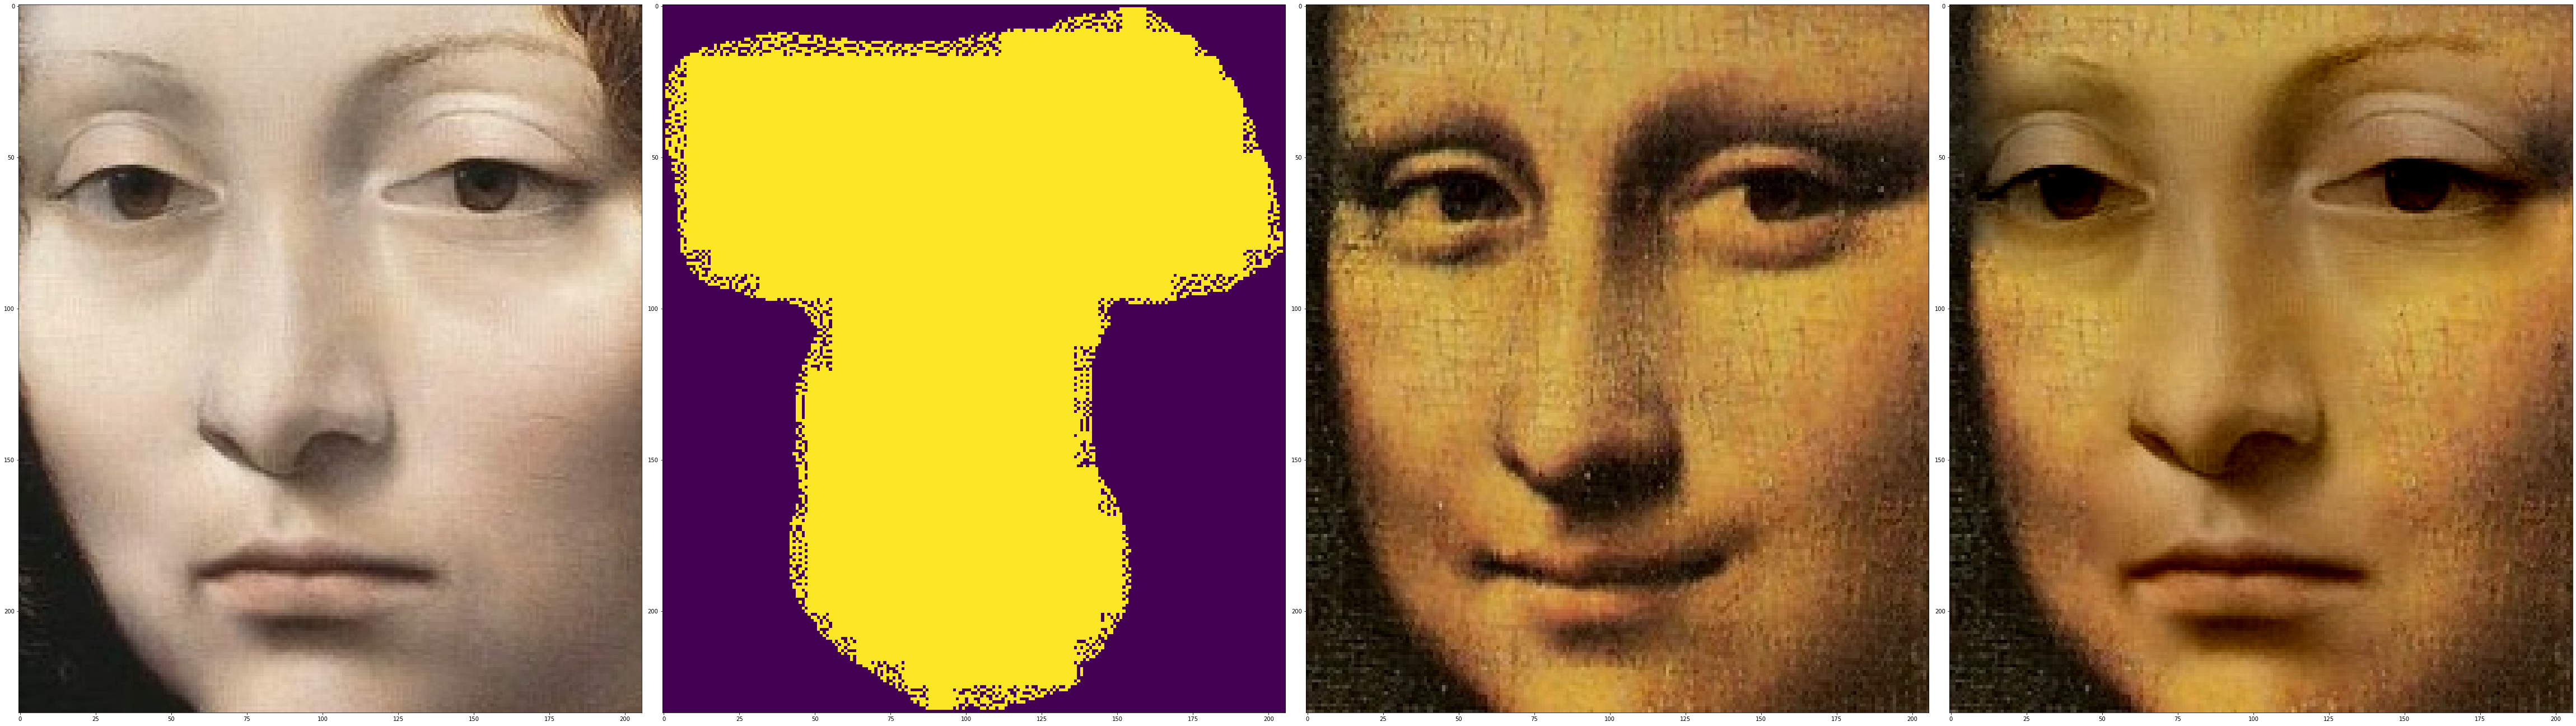

In [23]:
from scipy.ndimage import laplace
from skimage import io

def poisson_blend(target_img, src_img, mask_img, iter: int = 1024):
    for _ in range(iter):
        target_img = target_img + 0.25 * mask_img * laplace(target_img - src_img)
    return target_img.clip(0, 1)

# 画像のロード
src_img = io.imread("vinci_src.png",) / 255.0
target_img = io.imread("vinci_target.png",) / 255.0
mask_img = io.imread("vinci_mask.png") == 255

# マスク領域の切り出し(ソース)
src_coords = np.argwhere(mask_img)
src_top, src_left = np.min(src_coords, axis=0) - 1
src_bottom, src_right = np.max(src_coords, axis=0) + 1
mask_patch = mask_img[src_top : src_bottom + 1, src_left : src_right + 1]
src_patch = src_img[src_top : src_bottom + 1, src_left : src_right + 1]

# マスク領域の切り出し(ターゲット)
target_top, target_left = (src_top + target_img.shape[0] - src_img.shape[0], 30)
target_bottom, target_right = (
    target_top + mask_patch.shape[0],
    target_left + mask_patch.shape[1],
)
target_patch = target_img[target_top:target_bottom, target_left:target_right]

# RGB各チャンネルについて合成
blend_patch = np.stack(
    [
        poisson_blend(target_patch[:, :, i], src_patch[:, :, i], mask_patch)
        for i in range(3)
    ],
    axis=2,
)

# 結果の表示
plt.figure(figsize=(64, 64))
plt.subplot(1, 4, 1)
io.imshow(src_patch)
plt.subplot(1, 4, 2)
plt.imshow(mask_patch)
plt.subplot(1, 4, 3)
io.imshow(target_patch)
plt.subplot(1, 4, 4)
io.imshow(blend_patch)
plt.show()

## まとめ

* 輝度信号はG信号で代用してもなんとかなる
* Gaussian BlurをBox Blurで代用してもなんとかなる
* ソートすることなく中央値を計算することができる
* 積分画像はオーバーフローしていても問題ない
* ポアソン方程式に従って画像を合成すると割と良い感じにできる

## 参考文献

* Andrew S. Glassner, Graphics Gems, Morgan Kaufmann
* Alois Zingl, Extended Binomial Filter for Fast Gaussian Blur
* Patrick Perez, Michel Gangnet, Andrew Blake, Poisson Image Editing
* 参考書庫, http://www.sanko-shoko.net/index.php